 **Without Tradition Model**

Step 0: Loss = 1.8665, Val Loss = 1.1663, Accuracy = 0.2917, Val Accuracy = 0.2500, Train Entropy = 0.7905, Val Entropy = 0.9792
Step 50: Loss = 0.4247, Val Loss = 0.3096, Accuracy = 0.8542, Val Accuracy = 0.8750, Train Entropy = 0.4453, Val Entropy = 0.4516
Step 100: Loss = 0.4095, Val Loss = 0.2478, Accuracy = 0.8542, Val Accuracy = 0.9167, Train Entropy = 0.3916, Val Entropy = 0.3362
Step 150: Loss = 0.3458, Val Loss = 0.2712, Accuracy = 0.8542, Val Accuracy = 0.9167, Train Entropy = 0.3594, Val Entropy = 0.2602
Step 200: Loss = 0.2092, Val Loss = 0.3923, Accuracy = 0.9375, Val Accuracy = 0.9167, Train Entropy = 0.2928, Val Entropy = 0.2199
Step 250: Loss = 0.2185, Val Loss = 0.5872, Accuracy = 0.9271, Val Accuracy = 0.9167, Train Entropy = 0.2763, Val Entropy = 0.1956
Step 300: Loss = 0.2426, Val Loss = 0.5809, Accuracy = 0.9062, Val Accuracy = 0.9167, Train Entropy = 0.2974, Val Entropy = 0.1949
Step 350: Loss = 0.3238, Val Loss = 0.7560, Accuracy = 0.8646, Val Accuracy = 0.9167, 

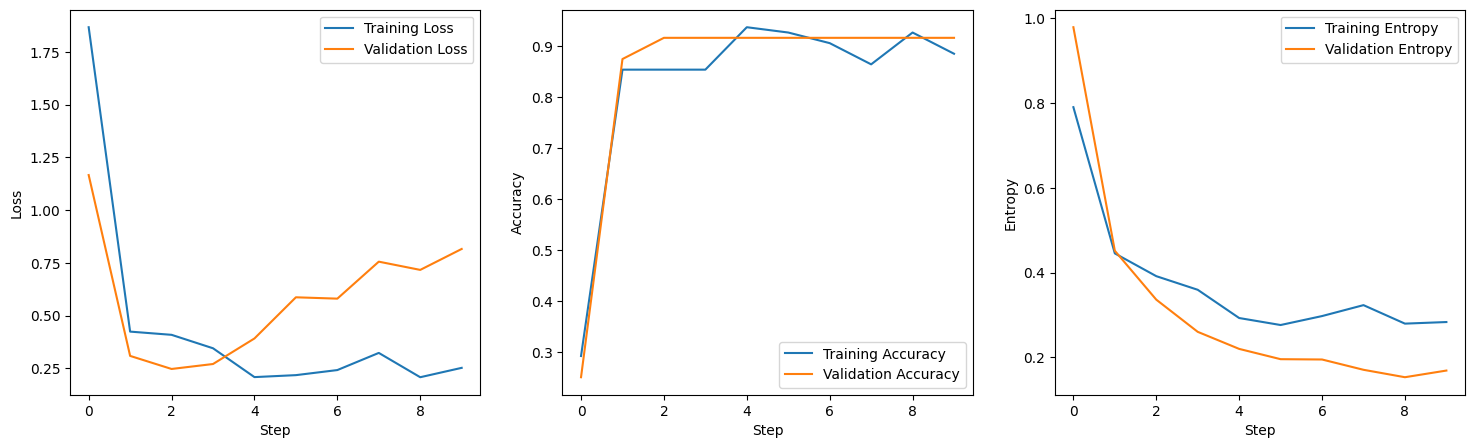

SKA Model Accuracy: 0.9667


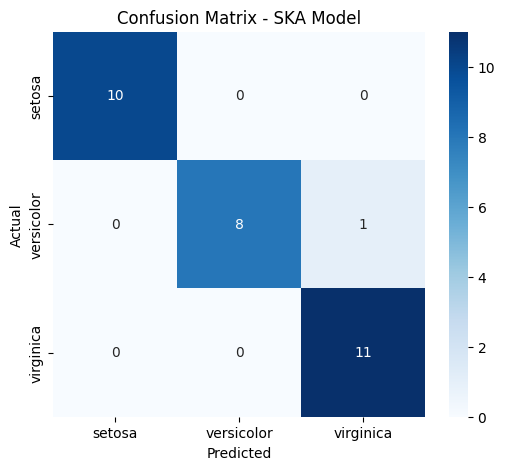

In [15]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the Iris dataset
data = load_iris()
X = data.data  # 4 features
y = data.target  # 3 classes

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert to PyTorch tensors and move to device
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class SKAModel(nn.Module):
    def __init__(self, input_size=4, layer_sizes=[16, 8, 3], K=500, weight_decay=0.001):
        super(SKAModel, self).__init__()
        self.layer_sizes = layer_sizes
        self.K = K  # Number of forward steps
        self.weight_decay = weight_decay

        # Initialize dual weights and biases with Xavier initialization
        self.weights = nn.ParameterList()
        self.dual_weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        prev_size = input_size
        for size in layer_sizes:
            weight = torch.empty(prev_size, size)
            dual_weight = torch.empty(prev_size, size)
            nn.init.xavier_normal_(weight)
            nn.init.xavier_normal_(dual_weight)
            self.weights.append(nn.Parameter(weight))
            self.dual_weights.append(nn.Parameter(dual_weight))
            self.biases.append(nn.Parameter(torch.zeros(size)))
            prev_size = size

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        for l in range(len(self.layer_sizes)):
            z = torch.mm(x, self.weights[l]) + torch.mm(x, self.dual_weights[l]) + self.biases[l]
            if l < len(self.layer_sizes) - 1:  # Hidden layers
                d = torch.relu(z)
                d = self.dropout(d)
            else:  # Output layer
                d = torch.softmax(z, dim=1)  # Use softmax for probabilities
            x = d
        return x

    def train_ska(self, X_train, y_train, X_val, y_val, learning_rate=0.01):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=self.weight_decay)

        losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        train_entropies = []
        val_entropies = []

        for k in range(self.K):
            self.train()
            outputs = self.forward(X_train)
            loss = self.compute_entropy_loss(outputs, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate on validation set
            if k % 50 == 0:
                self.eval()
                with torch.no_grad():
                    val_outputs = self.forward(X_val)
                    val_loss = self.compute_entropy_loss(val_outputs, y_val)
                    val_predictions = torch.argmax(val_outputs, dim=1)
                    val_labels = torch.argmax(y_val, dim=1)
                    val_accuracy = (val_predictions == val_labels).float().mean().item()

                    # Track entropy
                    train_entropy = self.compute_entropy(outputs)
                    val_entropy = self.compute_entropy(val_outputs)

                # Log training and validation progress
                predictions = torch.argmax(outputs, dim=1)
                labels = torch.argmax(y_train, dim=1)
                accuracy = (predictions == labels).float().mean().item()
                losses.append(loss.item())
                val_losses.append(val_loss.item())
                accuracies.append(accuracy)
                val_accuracies.append(val_accuracy)
                train_entropies.append(train_entropy.item())
                val_entropies.append(val_entropy.item())
                print(f"Step {k}: Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, "
                      f"Accuracy = {accuracy:.4f}, Val Accuracy = {val_accuracy:.4f}, "
                      f"Train Entropy = {train_entropy.item():.4f}, Val Entropy = {val_entropy.item():.4f}")

        # Plot loss, accuracy, and entropy
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.plot(losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(accuracies, label="Training Accuracy")
        plt.plot(val_accuracies, label="Validation Accuracy")
        plt.xlabel("Step")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(train_entropies, label="Training Entropy")
        plt.plot(val_entropies, label="Validation Entropy")
        plt.xlabel("Step")
        plt.ylabel("Entropy")
        plt.legend()
        plt.show()

    def compute_entropy_loss(self, outputs, y_true):
        # Cross-entropy loss using log probabilities
        log_probs = torch.log(outputs + 1e-10)  # Avoid log(0)
        loss = -torch.sum(y_true * log_probs) / y_true.shape[0]
        return loss

    def compute_entropy(self, outputs):
        # Compute entropy of the output probabilities
        return -torch.sum(outputs * torch.log(outputs + 1e-10), dim=1).mean()

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            outputs = self.forward(X)
            return torch.argmax(outputs, dim=1)

# Initialize and train SKA model
model = SKAModel(layer_sizes=[16, 8, 3], K=500, weight_decay=0.001).to(device)
model.train_ska(X_train, y_train, X_val, y_val, learning_rate=0.01)

# Evaluate SKA Model on test set
model.eval()
with torch.no_grad():
    y_pred = model.predict(X_test)
    y_test_labels = torch.argmax(y_test, dim=1)
    accuracy = accuracy_score(y_test_labels.cpu().numpy(), y_pred.cpu().numpy())
    conf_matrix = confusion_matrix(y_test_labels.cpu().numpy(), y_pred.cpu().numpy())

print(f"SKA Model Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix - SKA Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SKA Model Accuracy on 20 samples: 0.9500
Confusion Matrix:
[[5 0 0]
 [0 6 1]
 [0 0 8]]


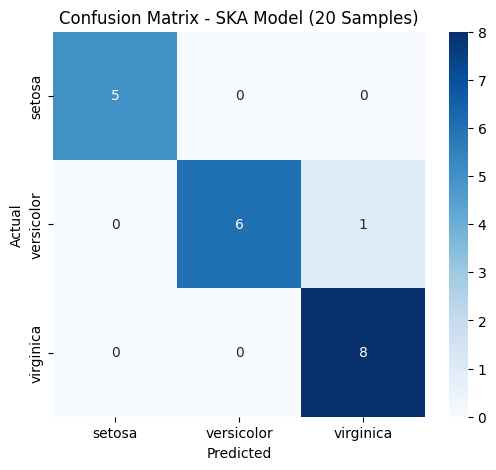

In [16]:

model.eval()
with torch.no_grad():

    subset_indices = np.random.choice(len(X_test), 20, replace=False)
    X_subset = X_test[subset_indices]
    y_subset = y_test[subset_indices]

    y_pred = model.predict(X_subset)
    y_true_labels = torch.argmax(y_subset, dim=1)

    accuracy = accuracy_score(y_true_labels.cpu().numpy(), y_pred.cpu().numpy())
    conf_matrix = confusion_matrix(y_true_labels.cpu().numpy(), y_pred.cpu().numpy())

    print(f"SKA Model Accuracy on 20 samples: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
    plt.title("Confusion Matrix - SKA Model (20 Samples)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Features, True Labels, and Predicted Labels for 20 Samples:
Sample 1:
  Features: [-1.021849   0.7888076 -1.2265517 -1.0521799]
  True Label: setosa
  Predicted Label: setosa

Sample 2:
  Features: [ 0.6745011 -0.592373   1.0469455  1.1855673]
  True Label: virginica
  Predicted Label: virginica

Sample 3:
  Features: [ 0.795669   -0.13197948  1.1606202   1.3171993 ]
  True Label: virginica
  Predicted Label: virginica

Sample 4:
  Features: [-0.29484183 -0.36217624 -0.08980314  0.13250974]
  True Label: versicolor
  Predicted Label: versicolor

Sample 5:
  Features: [ 1.0380048  -1.2829633   1.1606202   0.79067063]
  True Label: virginica
  Predicted Label: virginica

Sample 6:
  Features: [ 0.6745011 -0.592373   1.0469455  1.3171993]
  True Label: virginica
  Predicted Label: virginica

Sample 7:
  Features: [1.2803406  0.09821729 0.76275826 1.4488316 ]
  True Label: virginica
  Predicted Label: virginica

Sample 8:
  Features: [-0.53717756  0.7888076  -1.2833891  -1.0521799 ]
  True

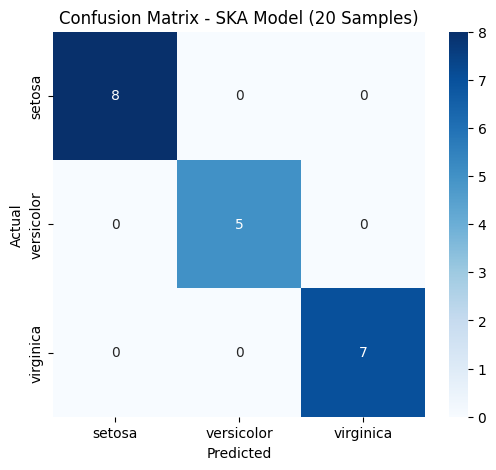

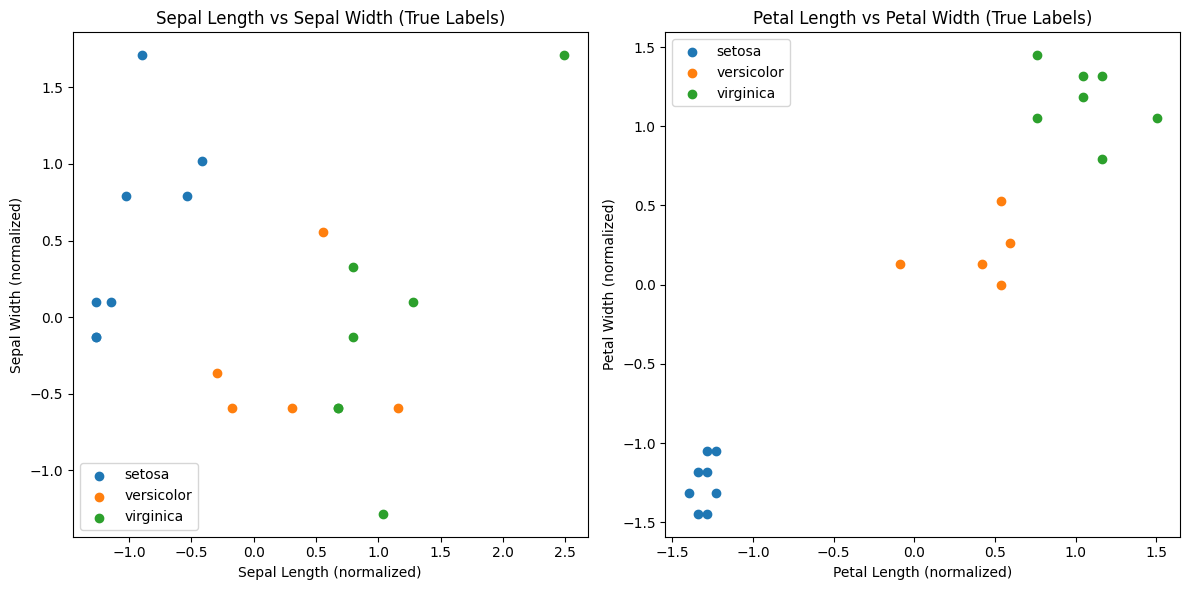

In [17]:
# Evaluate SKA Model on a subset of 20 test samples
model.eval()
with torch.no_grad():
    # Select 20 random samples from the test set
    subset_indices = np.random.choice(len(X_test), 20, replace=False)
    X_subset = X_test[subset_indices]
    y_subset = y_test[subset_indices]

    # Get predictions
    y_pred = model.predict(X_subset)
    y_true_labels = torch.argmax(y_subset, dim=1)

    # Convert tensors to numpy for easier handling
    X_subset_np = X_subset.cpu().numpy()
    y_true_labels_np = y_true_labels.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Print features, true labels, and predicted labels
    print("Features, True Labels, and Predicted Labels for 20 Samples:")
    for i in range(len(X_subset_np)):
        print(f"Sample {i + 1}:")
        print(f"  Features: {X_subset_np[i]}")
        print(f"  True Label: {data.target_names[y_true_labels_np[i]]}")
        print(f"  Predicted Label: {data.target_names[y_pred_np[i]]}")
        print()

    # Calculate accuracy for the subset
    accuracy = accuracy_score(y_true_labels_np, y_pred_np)
    conf_matrix = confusion_matrix(y_true_labels_np, y_pred_np)

    # Print results
    print(f"SKA Model Accuracy on 20 samples: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
    plt.title("Confusion Matrix - SKA Model (20 Samples)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Visualize the data using scatter plots
    plt.figure(figsize=(12, 6))

    # Scatter plot for sepal length vs sepal width
    plt.subplot(1, 2, 1)
    for i, species in enumerate(data.target_names):
        plt.scatter(X_subset_np[y_true_labels_np == i, 0], X_subset_np[y_true_labels_np == i, 1], label=species)
    plt.xlabel("Sepal Length (normalized)")
    plt.ylabel("Sepal Width (normalized)")
    plt.title("Sepal Length vs Sepal Width (True Labels)")
    plt.legend()

    # Scatter plot for petal length vs petal width
    plt.subplot(1, 2, 2)
    for i, species in enumerate(data.target_names):
        plt.scatter(X_subset_np[y_true_labels_np == i, 2], X_subset_np[y_true_labels_np == i, 3], label=species)
    plt.xlabel("Petal Length (normalized)")
    plt.ylabel("Petal Width (normalized)")
    plt.title("Petal Length vs Petal Width (True Labels)")
    plt.legend()

    plt.tight_layout()
    plt.show()

**With Traditional Model**

Epoch 0/200: Loss = 1.0874, Train Acc = 0.5312, Val Acc = 0.5417
Epoch 20/200: Loss = 0.7427, Train Acc = 0.8229, Val Acc = 0.8333
Epoch 40/200: Loss = 0.6077, Train Acc = 0.9792, Val Acc = 0.8750
Epoch 60/200: Loss = 0.5729, Train Acc = 0.9792, Val Acc = 0.8750
Epoch 80/200: Loss = 0.5642, Train Acc = 1.0000, Val Acc = 0.8750
Epoch 100/200: Loss = 0.5593, Train Acc = 1.0000, Val Acc = 0.8750
Epoch 120/200: Loss = 0.5566, Train Acc = 1.0000, Val Acc = 0.9167
Epoch 140/200: Loss = 0.5551, Train Acc = 1.0000, Val Acc = 0.9167
Epoch 160/200: Loss = 0.5541, Train Acc = 1.0000, Val Acc = 0.9167
Epoch 180/200: Loss = 0.5535, Train Acc = 1.0000, Val Acc = 0.9167
Final Test Accuracy: 0.9333


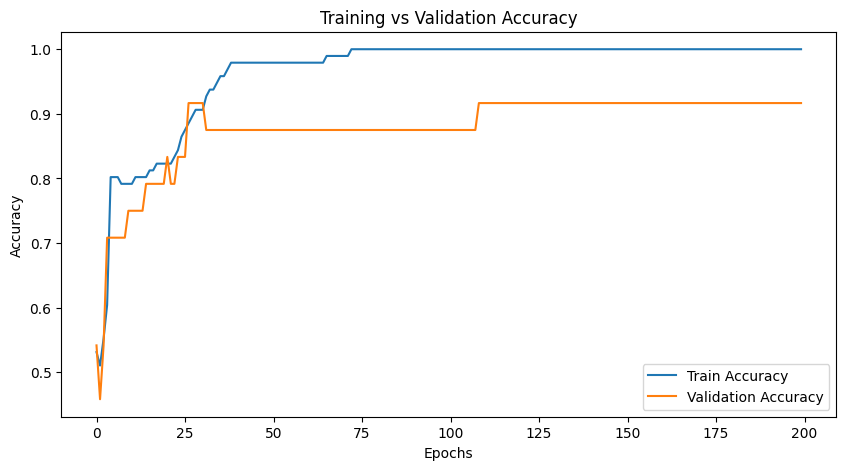

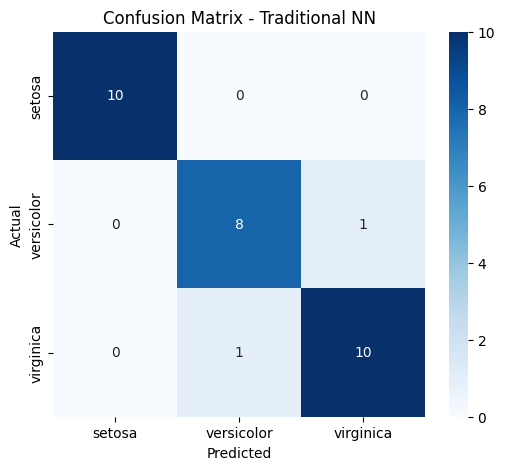

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the Iris dataset
data = load_iris()
X = data.data  # 4 features
y = data.target  # 3 classes

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert to PyTorch tensors and move to device
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size=4, hidden_size=16, output_size=3):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 8)
        self.fc3 = nn.Linear(8, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Initialize model, loss function, and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 200
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, torch.argmax(y_train, dim=1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    train_preds = torch.argmax(outputs, dim=1)
    train_labels = torch.argmax(y_train, dim=1)
    train_acc = (train_preds == train_labels).float().mean().item()
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    with torch.no_grad():
        val_outputs = model(X_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_labels = torch.argmax(y_val, dim=1)
        val_acc = (val_preds == val_labels).float().mean().item()
        val_accuracies.append(val_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs}: Loss = {loss.item():.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

# Evaluate on test set
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_labels = torch.argmax(y_pred, dim=1)
    y_test_labels = torch.argmax(y_test, dim=1)
    accuracy = accuracy_score(y_test_labels.cpu().numpy(), y_pred_labels.cpu().numpy())
    conf_matrix = confusion_matrix(y_test_labels.cpu().numpy(), y_pred_labels.cpu().numpy())

print(f"Final Test Accuracy: {accuracy:.4f}")

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix - Traditional NN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
